- MySQL 로 Replication(복제)을 구성 시 Binlog타입을 Statement/Row/Mixed로 설정할 수 있음.

- Binlog(Binary Log)는 데이터 변경 시, 변경 내역들을 쭉 저정해놓은 로그들로,
특정 시점 데이터가 있다면, 그 이후부터 Binlog를 적용한다면, 시점 복구까지 가능.

- Statement Format : 가장 오래된 Format으로 데이터 변경에서 사용되는 모든 쿼리를 쿼리대로 저장하는 방식을 말함(5.7까지 기본 Format)

- Row Format : 변경 작업으로 변경된 모든 Row의 정보를 기록하는 방식

- Mixed Format : Statement 방식과 Row 방식을 혼합한 방식으로 기본은 Statement 방식이고, 몇몇의 경우에는 Row방식으로 동작하는 방식





**Row 와 Statement**

- 데이터베이스에 작은 변경을 많이 발생 시키는 쓰레드는 열 기반 로깅을 선호.
  - WHERE 구문에 있는 많은 열과 매치가 되는 업데이트를 실행하는 쓰레드는 명령문 기반 로깅을 선호하는데, 그 이유는 많은 열을 로깅하는 것 보다는 적은 명령문 로깅이 효과적이기 때문.
- 마스터에서 오랜 실행 시간 동안 실행되지만 비교적 적은 수의 열만을 수정하는 명령문들이 있음.
  - 이러한 명령문들은 열 기반 로깅을 사용해서 복제하는 것이 보다 효과적

# **Statement 기반 바이너리 로그 포맷**

- 다수의 데이터가 수정된 경우에도 단순히 쿼리만 기록되기에 적은 용량의 로그파일을 관리할 수 있다는 장점

**제한사항**

**REPEATABLE-READ 이상의 트랜잭션 격리 수준 사용**

- MySQL의 기본 격리 수준인 REPEATABLE-READ 이상을 사용해야만 함.
- READ-COMMITTED 방식의 경우 하나의 트랜잭션에서 실행 시점에 따라 스냅샷이 달라지기 때문에 데이터가 불일치하는 문제가 발생할 수 있음.



**비 확정적으로 처리되는 쿼리문 사용 불가**

- 아래의 쿼리문과 같이 정확한 결과 값을 추론할 수 없는 경우. 소스와 레플리카의 데이터가 일치하지 않을 수 있음.


- 동일한 파라미터 값을 입력하더라도 결과가 달라질 수 있는 사용자 정의 함수나 프로시저를 사용하는 쿼리



```
DELETE/UPDATE 쿼리에서 ORDER BY 없이 사용

SELECT ... FOR UPDATE 및 SELECT ... FOR SHARE쿼리에서 NOWAIT이나 SKIP LOCKED 사용

LOAD_FILE(), UUID(), UUID_SHORT(), USER(), FOUND_ROWS(), RAND(), VERSION() 등과 같은 함수를 사용하는 쿼리
```

- 간단한 예시로 uuid() 함수를 통해 데이터를 생성할 경우 데이터 값이 달라 질 수 있으며 이후 해당 데이터를 uuid() 기준으로 삭제할 때 레플리카의 데이터만 남게되는 문제가 발생하게 됨


```
INSERT INTO test.tb_person(name,age,uuid) values ('Omty',20,uuid())
```

**Row 포맷보다 더 많은 Lock을 사용**

- 데이터가 복사되는 Row 포맷과 달리 쿼리문을 호출하는 방식이기에 조건에 따라 더 많은 Lock을 걸어 복제 지연이 발생할 수 있음.





# **Row 기반 바이너리 로그 포맷**

- Row 방식의 경우 데이터를 로깅하는 방식이기에 복제 시 소스와 레플리카 서버의 데이터 일관성을 유지하는 안전한 방식


**Statement 방식과 차이점**

- 변경된 데이터가 바로 적용되기에 더 적은 Lock을 점유
- 모든 트랜잭션에서 사용이 가능
- 쿼리 결과에 의한 값을 전달하기에 변경된 데이터가 많을 수록 바이너리 로그 파일 크기가 커짐
- 다만 사용자 계정 생성 및 구한 또는 CREATE , ALTER, DROP 등 DDL 문의 경우 STATEMENT 형태로 로깅.


**Row 포맷 Binary 파일 확인 방법**

- Row 포맷의 경우 실행된 쿼리를 확인하기 어렵기 때문에 mysqlbinlog 사용 시 옵션을 통해 쿼리 형태로 확인할 수 있는 기능을 제공.

> -v : 변경된 데이터를 유사 SQL 형태로 변환
>
> -vv : -v 옵션의 변경된 데이터에 타입을 추가로 표시함
>
> --base64-output=DECODE-ROWS : Base64 문자열로 인코딩된 변경 데이터를 표시하지 않음



```
$ mysqlbinlog -uroot -p -v --base64-output=DECODE-ROWS binlog.000011 > binlog.sql
```

# **Mixed 포맷**

- Mixed 포맷의 경우 Statement방식과 Row방식을 혼합하여 사용
- 기본적으로는 Statement 방식을 사용하며 실행된 쿼리와 스토리지 엔진의 종류에 따라 필요시 자동으로 Row포맷으로 전환 후 로그에 기록.
  - 예시로 Statement 에서 비 확정적으로 처리되는 쿼리문의 경우 Row 포맷으로 전환되어 기록.
  - 장점만 합쳐놨다면 Mixed 포맷이 가장 좋다고 생각될 수 있지만 간혹 예상치 못한 방식으로 로깅될 가능성 또한 존재.



**복제 포맷 적용**

```
[mysqld]

--binlog-format=formt

-- 전역
mysql> SET GLOBAL binlog_format = 'STATEMENT';
mysql> SET GLOBAL binlog_format = 'ROW';
mysql> SET GLOBAL binlog_format = 'MIXED';

-- 세션
mysql> SET SESSION binlog_format = 'STATEMENT';
mysql> SET SESSION binlog_format = 'ROW';
mysql> SET SESSION binlog_format = 'MIXED';
```

- binlog_format은 동적으로 수정이 가능하며 Session 단위 적용이 가능.
- ROW 방식을 사용 중일 때 대량의 변경 사항 적용이 필요할 경우 해당 내용만 SESSION으로 Statement 포맷을 적용하게 되면 파일이 커지는 것을 방지 할 수 있음.

- 반대로 Statement 방식일 때 쿼리 실행 시간에 비해 변경되는 데이터가 적을 경우 Row 방식을 사용하면 처리 시간 및 Lock 점유를 줄일 수 있음.



**예외**

- 임시 테이블을 사용하는 경우 Statement 포맷은 기록이 되나 ROW 포맷의 경우 기록되지 않음.




**Format 변경시 문제 발생하는 시점**

- Trigger나 Stored Function을 사용하고 있는 경우
- NDB Cluster Storage Engine을 사용하고 있는 경우
- 현재 Temporary Table을 사용하고 있는 세션이 있는 경우(세션이 행 기반 복제 모드이고 열린 임시테이블이 존재할 경우)



**Storage Engine별로 지원하는 포멧**

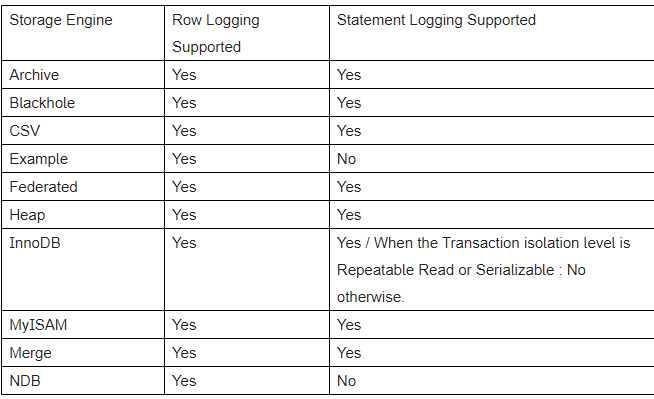

**Storage Engine별 지원하는 logging 형태에 따라 2가지로 분류**
- SLC (Statement-Logging Capable) - Statement Logging Storage
Engine.
- RLC (Row-Logging Capable) - Row Logging 방식을 지원하는 Storage Engine

**Binary Log에 작성되는 3가지 종류**

- Safe : Statement 방식으로 작성 시 Replication 이나 복구 시에 문제가 되지 않는 쿼리 형태
- UnSafe : Statement 방식으로 작성 시 Replication 이나 복구 시에 문제가 되는 쿼리 형태
- Row/Binary Injection : Row Event로 Row Based 방식으로 실행하기 위해 저장되는 Event형태 (Row format 으로 로깅해야 지만, 변경 내역이 저장되는 것을 의미)

**MySQL은 Grant 작업은 직접적인 DML로 진행될 수도 있으나 간접적인 DDL 구문으로 실 행가능**

- 직접적으로 실행되는 DML 는 Binlog_format에 따라 작성되는 방법이 다름 (Insert / Update / Delete / Replace / Do/ Load Data Infile / Select / Truncate table)
- 간접적으로 실행되는 DDL 문은 Binlog_format과 상관없이 무조건 Statement방식으로 저장(Grant / Revoke / Set Password / Rename User / Create / Alter Drop)
- Create table .. Select 경우 Create Table 은 Statement 방식으로 저장되고 Select 부분 은 Binlog_format 설정값에 따라 달라짐

**주의 사항**

- InnoDB 테이블을 사용 중이고 트랜잭션 격리 수준이 READ COMMITTED 또는 READ UNCOMMITTED인 경우 STATEMENT format은 사용할 수 없고, ROW format만 사용할 수 있음.
  - 하지만 READ-COMMITED 환경에서는 다른세션에서 commit 발생시 트랜잭션에서 조회하는 데이터가 달라지기 때문에 원본 DB와 동일한 결과값을 보장할 수 없음.
-  REPEATABLE READ 환경에서는 트랜잭션 내에서 읽기 일관성을 보장하기 때문에, statement 단위로 로깅해도 원본 DB와 동일한 결과를 보장.
- source 서버의 binlog format변경은 replica에 반영되지 않음
- replica는 row format binlog를 statment format으로 변환해서 사용할수 없음.
  - 따라서 source서버가 row format을 사용하면 replica도 row format을 사용해야함.